In [2]:
from zipfile import ZipFile

with ZipFile("drive/My Drive/AM/Project-OCR/noisydata_all.zip", 'r') as zip_:
    print('Extracting...') 
    zip_.extractall()
    print('Done!')

Extracting...
Done!


In [3]:
import os
import cv2
import numpy as np

import seaborn as sns
from matplotlib import pyplot

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
orig_images = []
noisy_images = []
for img_name in os.listdir("noisy_data/"):
    if "orig" in img_name:
        orig_images.append(img_name)
    else:
        noisy_images.append(img_name)

orig_images = sorted(orig_images, key=lambda x: int(x.split("_")[0]))
noisy_images = sorted(noisy_images, key=lambda x: int(x.split("_")[0]))

assert len(orig_images) == len(noisy_images)

In [5]:
Xorig, Xnoisy = [], []

for o_img, n_img in zip(orig_images, noisy_images):
    img = cv2.imread("noisy_data/"+o_img, 0)
    img = np.expand_dims(img, 2)
    Xorig.append(img)

    img = cv2.imread("noisy_data/"+n_img, 0)
    img = np.expand_dims(img, 2)
    Xnoisy.append(img)

Xorig = np.array(Xorig)
Xnoisy = np.array(Xnoisy)

Xorig.shape, Xnoisy.shape

((4356, 80, 256, 1), (4356, 80, 256, 1))

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnoisy, Xorig, train_size=0.85, random_state=42)

Xtrain = Xtrain.astype('float32') / 255.
Xtest = Xtest.astype('float32') / 255.
ytrain = ytrain.astype('float32') / 255.
ytest = ytest.astype('float32') / 255.

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3702, 80, 256, 1), (654, 80, 256, 1), (3702, 80, 256, 1), (654, 80, 256, 1))

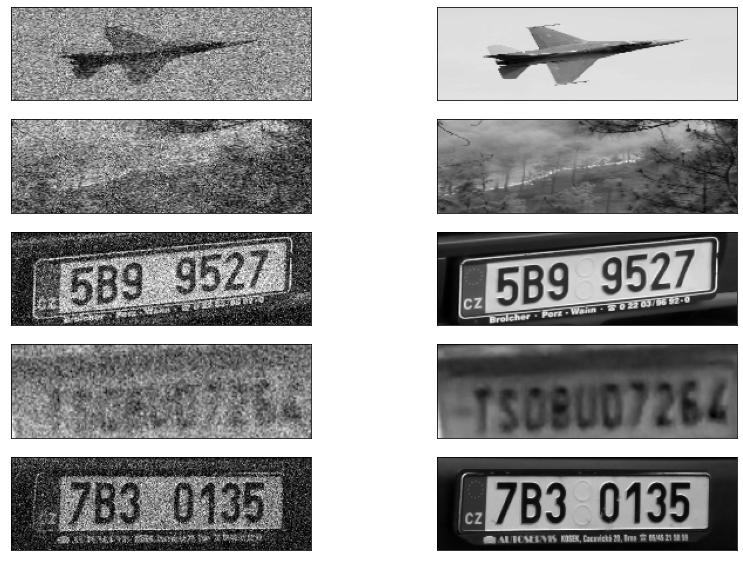

In [7]:
sns.reset_orig()

fig = pyplot.figure(1, (14, 10))

i = 1
for idx in np.random.randint(0,200,5):
    img = Xtrain[idx,:,:,0]
    ax = pyplot.subplot(5,2, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = ytrain[idx,:,:,0]
    ax = pyplot.subplot(5,2, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

In [0]:
def encoder_block(X, filters: list, blockid: int, do_rate: float = 0.):
    X = Conv2D(
        filters=filters[0],
        kernel_size=(3,3),
        padding="same",
        kernel_initializer = he_normal(seed=42),
        name=f"encblock{blockid}_conv1"
    )(X)
    X = BatchNormalization(name=f"enclock{blockid}_bn1")(X)
    X = Activation('relu', name=f"encblock{blockid}_actv1")(X)
    X = Conv2D(
        filters=filters[1],
        kernel_size=(3,3),
        padding="same",
        kernel_initializer = he_normal(seed=42),
        name=f"encblock{blockid}_conv2"
    )(X)
    X = BatchNormalization(name=f"encblock{blockid}_bn2")(X)
    X = Activation('relu', name=f"encblock{blockid}_actv2")(X)

    X = MaxPooling2D(pool_size=(2, 2), padding="same", name=f"encblock{blockid}_maxpool1")(X)
    if do_rate > 0.:
        X = Dropout(rate=do_rate, name=f"encblock{blockid}_do1")(X)
    
    return X

In [0]:
def decoder_block(X, filters: list, blockid: int, do_rate: float = 0.):
    X = Conv2D(
        filters=filters[0],
        kernel_size=(3,3),
        padding="same",
        kernel_initializer = he_normal(seed=42),
        name=f"decblock{blockid}_conv1"
    )(X)
    X = BatchNormalization(name=f"decblock{blockid}_bn1")(X)
    X = Activation('relu', name=f"decblock{blockid}_actv1")(X)
    X = Conv2D(
        filters=filters[1],
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer = he_normal(seed=42),
        name=f"decblock{blockid}_conv2"
    )(X)
    X = BatchNormalization(name=f"decblock{blockid}_bn2")(X)
    X = Activation('relu', name=f"decblock{blockid}_actv2")(X)

    X = UpSampling2D((2, 2), name=f"decsample_{blockid}")(X)
    if do_rate > 0.:
        X = Dropout(rate=do_rate, name=f"decblock{blockid}_do1")(X)
    
    return X

In [0]:
def denoiser(img_shape, show_summary=False):
    model_in  = Input(shape=img_shape, name="input_layer")

    X = encoder_block(model_in, filters=[16, 32], blockid=1)
    X = encoder_block(X, filters=[64, 128], blockid=2)
    X = encoder_block(X, filters=[256, 512], blockid=3)

    X = decoder_block(X, filters=[512, 256], blockid=1)
    X = decoder_block(X, filters=[128, 64], blockid=2)
    X = decoder_block(X, filters=[32, 16], blockid=3)

    model_out = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(X)
    model = Model(inputs=model_in, outputs=model_out, name="Denoiser_AutoEncoder")

    if show_summary:
        model.summary()
    
    return model

In [18]:
model = denoiser((80, 256, 1), show_summary=True)
# plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

Model: "Denoiser_AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 80, 256, 1)]      0         
_________________________________________________________________
encblock1_conv1 (Conv2D)     (None, 80, 256, 16)       160       
_________________________________________________________________
enclock1_bn1 (BatchNormaliza (None, 80, 256, 16)       64        
_________________________________________________________________
encblock1_actv1 (Activation) (None, 80, 256, 16)       0         
_________________________________________________________________
encblock1_conv2 (Conv2D)     (None, 80, 256, 32)       4640      
_________________________________________________________________
encblock1_bn2 (BatchNormaliz (None, 80, 256, 32)       128       
_________________________________________________________________
encblock1_actv2 (Activation) (None, 80, 256, 3

In [0]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.001,
    factor=0.1,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=9,
    verbose=1,
    restore_best_weights=True,
)

In [20]:
model.compile(
    optimizer=optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['mae']
)

history = model.fit(
    x=Xtrain,
    y=ytrain,
    batch_size=16,
    epochs=30,
    validation_data=(Xtest, ytest),
    callbacks=[lr_scheduler]
)

Epoch 1/30
232/232 [==============================] - 25s 109ms/step - loss: 0.5604 - mae: 0.0794 - val_loss: 0.5952 - val_mae: 0.0936 - lr: 0.0010
Epoch 2/30
232/232 [==============================] - 26s 110ms/step - loss: 0.5491 - mae: 0.0630 - val_loss: 0.5740 - val_mae: 0.0664 - lr: 0.0010
Epoch 3/30
232/232 [==============================] - 25s 109ms/step - loss: 0.5473 - mae: 0.0603 - val_loss: 0.6877 - val_mae: 0.1050 - lr: 0.0010
Epoch 4/30
232/232 [==============================] - 25s 109ms/step - loss: 0.5445 - mae: 0.0550 - val_loss: 0.5466 - val_mae: 0.0524 - lr: 0.0010
Epoch 5/30
232/232 [==============================] - 25s 109ms/step - loss: 0.5457 - mae: 0.0578 - val_loss: 0.7261 - val_mae: 0.1346 - lr: 0.0010
Epoch 6/30
232/232 [==============================] - 25s 109ms/step - loss: 0.5436 - mae: 0.0539 - val_loss: 0.5425 - val_mae: 0.0484 - lr: 0.0010
Epoch 7/30
232/232 [==============================] - 25s 109ms/step - loss: 0.5419 - mae: 0.0501 - val_loss: 0.

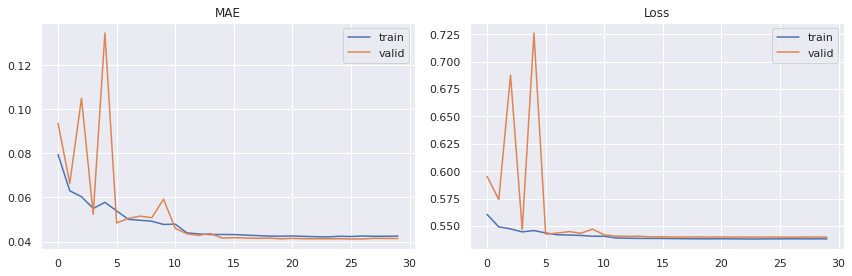

In [21]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['mae'], label='train')
sns.lineplot(history.epoch, history.history['val_mae'], label='valid')
pyplot.title('MAE')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.show()

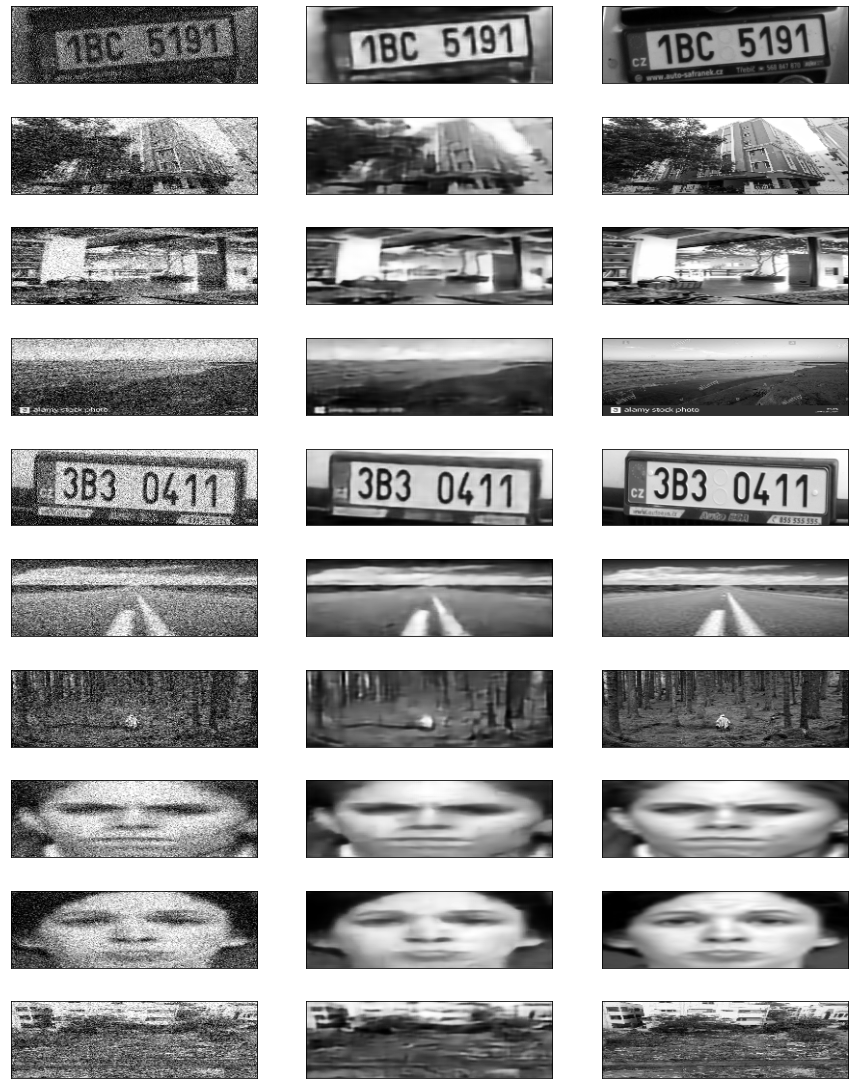

In [22]:
sns.reset_orig()

fig = pyplot.figure(1, (15, 20))

i = 1
for idx in np.random.randint(0,250,10):
    img = Xtrain[idx,:,:,0]
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = model.predict(np.expand_dims(Xtrain[idx,:,:,0], 0))
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img[0,:,:,0], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = ytrain[idx,:,:,0]
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

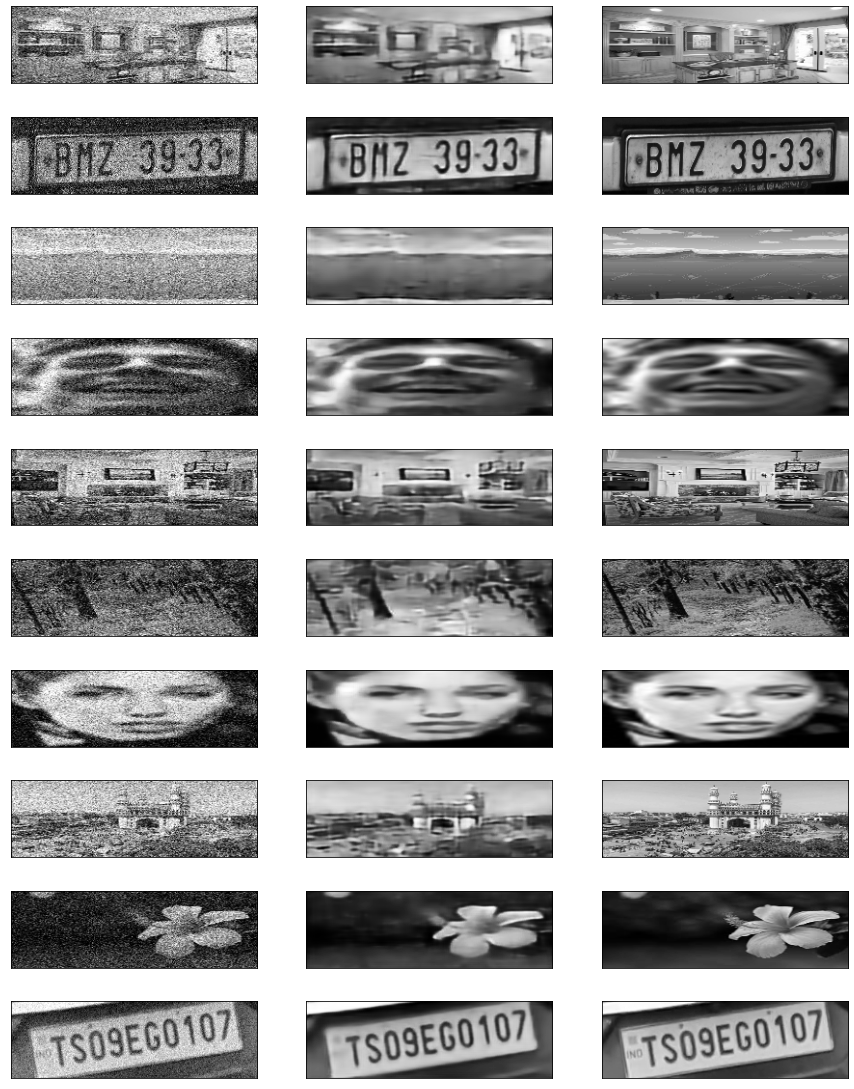

In [23]:
sns.reset_orig()

fig = pyplot.figure(1, (15, 20))

i = 1
for idx in np.random.randint(0,250,10):
    img = Xtest[idx,:,:,0]
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = model.predict(np.expand_dims(Xtest[idx,:,:,0], 0))
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img[0,:,:,0], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

    img = ytest[idx,:,:,0]
    ax = pyplot.subplot(10,3, i)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1